# Combinando Modelos e dados: COVID-19

Ao se modelar uma epidemia real, a concordância do modelo e os dados observados é de extrema importância.

Neste Notebook vamos estudar o Modelo SEIAHR proposto para a COVID-19 por [Coelho et al](https://www.medrxiv.org/content/10.1101/2020.06.15.20132050v1). Neste modelo, temos os seguintes compartimentos:
![diagrama](seiahr.jpg)

Matemáticamente:
$$\begin{align}
\frac{dS}{dt}&=-\lambda [(1-\chi) S],\\
\frac{dE}{dt}&= \lambda [(1-\chi) S]-\alpha E,\\
\frac{dI}{dt}&= (1-p)\alpha E - \delta I -\phi I,\\
\frac{dA}{dt}&= p\alpha E - \gamma A,\\
\frac{dH}{dt}&= \phi I -(\rho+\mu) H,\\
\frac{dR}{dt}&= \delta I + \rho H+\gamma A,
\end{align}
$$

Para facilitar nosso trabalho com dados dentro do ambiente Sage, precisamos instalar o Pandas para isso
em um terminal use o seguinte comando: 
```
sage -sh
```
este comando iniciará uma subsessão do sage onde você poderá instalar o pandas com o comando usual:
```
pip install pandas
pip install parameter-sherpa
exit
```
o comando `exit` após a instalação visa sair da subsessão do Sage.

In [22]:
import numpy as np
import pandas as pd
%display typeset

In [23]:
def model(t, y, params):
    S, E, I, A, H, R, C, D = y
    chi, phi, beta, rho, delta, gamma, alpha, mu, p, q, r = params
    lamb = beta * (I + A)
    # Turns on Quarantine on day q and off on day q+r
    chi *= ((1 + np.tanh(t - q)) / 2) * ((1 - np.tanh(t - (q + r))) / 2)
    return [
        -lamb * ((1 - chi) * S),  # dS/dt
        lamb * ((1 - chi) * S) - alpha * E,  # dE/dt
        (1 - p) * alpha * E - delta * I - phi * I,  # dI/dt
        p * alpha * E - gamma * A,
        phi * I - (rho + mu) * H,  # dH/dt
        delta * I + rho * H + gamma * A,  # dR/dt
        phi * I,  # (1-p)*alpha*E+ p*alpha*E # Hospit. acumuladas
        mu * H  # Morte acumuladas
    ]           

In [35]:
chi = .3
phi = 0.012413633926076584
beta = 0.27272459855759813
rho = 0.2190519831830368
delta = 0.04168480042146949
gamma = 0.04
alpha =  0.3413355572047603
mu = 0.02359234606623134
p = 0.7693029079871165
q = 50
r = 55

In [36]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [.99, 0, 1e-4, 0, 0, 0, 0, 0]
tspan = [0,200]
T.ode_solve(tspan, inits, num_points=200, params=[chi,phi,beta,rho,delta,gamma,alpha,mu,p,q,r])

In [37]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[9.90000000e-01, 0.00000000e+00, 1.00000000e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.89973344e-01, 2.25755111e-05, 9.56580086e-05, ...,
        4.23720621e-06, 1.21233870e-06, 1.33047275e-08],
       [9.89946090e-01, 3.91711356e-05, 9.30197071e-05, ...,
        8.76177490e-06, 2.38193156e-06, 4.86367287e-08],
       ...,
       [7.05921911e-03, 4.50726801e-05, 5.18874882e-04, ...,
        9.70886461e-01, 5.19350779e-02, 5.04644718e-03],
       [7.04595718e-03, 4.32611015e-05, 4.94934735e-04, ...,
        9.71170175e-01, 5.19413692e-02, 5.04720754e-03],
       [7.03322409e-03, 4.15259091e-05, 4.72119417e-04, ...,
        9.71443013e-01, 5.19473704e-02, 5.04793268e-03]])

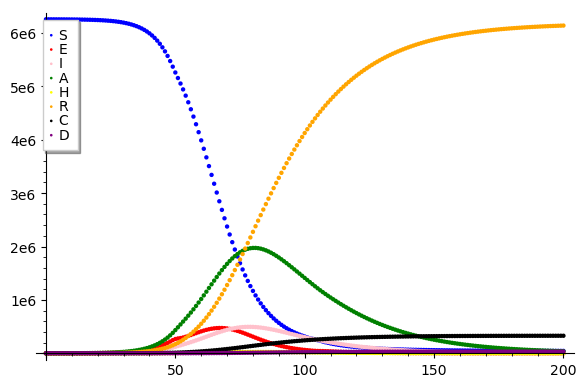

In [38]:
popRJ = 6.32e6
def plot_sol(sol):
    sim = get_sim_array(sol)*popRJ
    P = list_plot(sim[:,0],legend_label='S')
    colors = ['blue','red','pink','green','yellow','orange','black','purple']
    for i,var in enumerate(['E','I','A','H','R','C','D']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P)
plot_sol(T.solution)

In [39]:
sims = get_sim_array(T.solution)
sims[-1,-2]*popRJ

328307.38107624033

## Obtendo os dados
Os dados usados aqui foram obtidos do site [Brasil.io](https://brasil.io). Apenas os dados do estado do Rio de Janeiro foram extraídos e salvos em um CSV. 

In [40]:
def load_data(state):
    df = pd.read_csv(f'dados_{state}.csv')
    df['data'] = pd.to_datetime(df.data)
#     df.set_index('data', inplace=True)
    return df

In [41]:
dfRJ = load_data('RJ')
ld = len(dfRJ)
html(dfRJ.tail().to_html())

,data,date,last_available_confirmed,last_available_deaths,incidencia_casos,incidencia_morte,ew
170,2020-08-22,2020-08-22,210464,15267,65.0,3428.0,34
171,2020-08-23,2020-08-23,210948,15292,25.0,484.0,35
172,2020-08-24,2020-08-24,211360,15392,100.0,412.0,35
173,2020-08-25,2020-08-25,214003,15560,168.0,2643.0,35
174,2020-08-26,2020-08-26,214003,15560,0.0,0.0,35


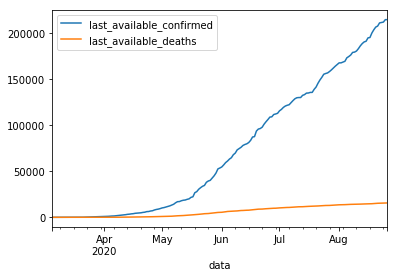

In [42]:
subnot=1
dfRJ.set_index('data')[['last_available_confirmed','last_available_deaths']].plot()
#dfRJ.set_index('data')['last-available-deaths'].plot()

## Ajustando o Modelo aos dados
Há muitas formas de se ajustar um modelo dinâmico aos dados disponíveis. Vamos começar por meio de otimização, buscando os valores de parâmetros que minimizam o desvio entre o modelo e os dados. O ajuste será feito simultaneamente para casos e mortes acumuladas. Abaixo vamos importar a biblioteca [Sherpa](https://parameter-sherpa.readthedocs.io/en/latest/gettingstarted/guide.html):

In [44]:
import sherpa

Começamos por definir o tipo de variável de cada parâmetro, e o tipo de algoritmo de busca que utilizaremos.

In [97]:
parameters = [
    sherpa.Continuous(name='chi',range=[0,.3]),
    sherpa.Continuous(name='phi',range=[0,1]),
    sherpa.Continuous(name='beta',range=[0.1,2]),
    sherpa.Continuous(name='rho',range=[0.2,1]),
    sherpa.Continuous(name='delta',range=[0.01,1]),
    sherpa.Continuous(name='gamma',range=[0.01,1]),
    sherpa.Continuous(name='alpha',range=[0.01,1]),
    sherpa.Continuous(name='mu',range=[0.01,.7]),
    sherpa.Continuous(name='p',range=[0.01,.7]),
    sherpa.Discrete(name='q',range=[1,30]),
    sherpa.Discrete(name='r',range=[1,12]),
    sherpa.Discrete(name='t0',range=[0,25]),
]
algorithm = sherpa.algorithms.RandomSearch(max_num_trials=1000)
# algorithm = sherpa.algorithms.GPyOpt(model_type='GP',max_num_trials=150)

In [98]:
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=True,
                     disable_dashboard=True)


Uma vez definido o problema (`study`) podemos gerar uma sugestão valores para ver como funciona:

In [99]:
trial = study.get_suggestion()
trial.parameters

{'chi': 0.23368286764639207,
 'phi': 0.8119516755889445,
 'beta': 1.0319439601097884,
 'rho': 0.2595434423167018,
 'delta': 0.8353324894580054,
 'gamma': 0.5864727696071707,
 'alpha': 0.32720911380290574,
 'mu': 0.11882826845623522,
 'p': 0.5158678412879205,
 'q': 4,
 'r': 5,
 't0': 2}

Então podemos executar a busca de parâmetros em um simples loop

In [100]:
for trial in study:
    pars = [trial.parameters[n] for n in ['chi', 'phi', 'beta', 'rho', 'delta', 'gamma', 'alpha', 'mu', 'p', 'q', 'r']]
    t0 = trial.parameters['t0']
    T.ode_solve(tspan, inits, num_points=200, params=pars)
    sim = get_sim_array(T.solution)
    H = sim[:ld+t0,-2]*popRJ
    D = sim[:ld+t0,-1]*popRJ
    loss = sum((dfRJ.last_available_confirmed-H[t0:t0+ld])**2) +sum((dfRJ.last_available_deaths-D[t0:t0+ld])**2)/2*ld
    study.add_observation(trial=trial,
                          objective=loss,
                          )
    study.finalize(trial)

In [101]:
res = study.get_best_result()
res

{'Trial-ID': 565,
 'Iteration': 1,
 'alpha': 0.39844829548134364,
 'beta': 1.0693632980850178,
 'chi': 0.21501185995444017,
 'delta': 0.8268717740088117,
 'gamma': 0.7337334818039278,
 'mu': 0.17495987609300237,
 'p': 0.6955495718112924,
 'phi': 0.0962650060760134,
 'q': 17,
 'r': 10,
 'rho': 0.8248709048489531,
 't0': 12,
 'Objective': 471373926841.18994}

In [102]:
def plot_results(pars):
    T.ode_solve(tspan, inits, num_points=200, params=list(pars[:-1]))
    t0=pars[-1]
    sim = get_sim_array(T.solution)*popRJ
    h = list_plot(sim[:ld+t0,-2],color='red',legend_label='Cum. cases', plotjoined=True)
    d = list_plot(sim[:ld+t0,-1],color='purple', legend_label='Cum. Deaths', plotjoined=True)
    cc = list_plot(list(zip(range(t0,ld+t0),dfRJ.last_available_confirmed)), color='black',legend_label='cases (obs)')
    cd = list_plot(list(zip(range(t0,ld+t0),dfRJ.last_available_deaths)), color='orange',legend_label='deaths(obs)')
    show(h+d+cc+cd)

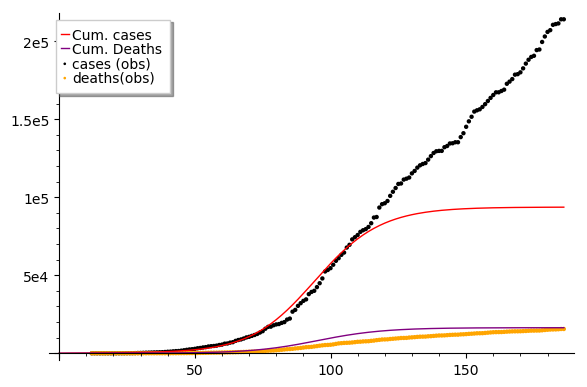

In [103]:
plot_results([res['chi'],
              res['phi'],
              res['beta'],
              res['rho'],
              res['delta'],
              res['gamma'],
              res['alpha'],
              res['mu'],
              res['p'],
              res['q'],
              res['r'],
              res['t0']
             ])